# Small Spec Exploration

Explore exploitability trajectories from `artifacts/benchmark_runs/*/metrics.json`.
We plot `2*predicted_avg - 1` on log-log axes and group by spec features.


In [1]:
import os, sys, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def find_repo_root(start_dir: str) -> str:
    cur = os.path.abspath(start_dir)
    for _ in range(6):
        if os.path.isdir(os.path.join(cur, "liars_poker")) or os.path.exists(os.path.join(cur, "pyproject.toml")):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            break
        cur = parent
    return os.path.abspath(os.path.join(start_dir, "..", ".."))

NB_DIR = os.getcwd()
REPO_ROOT = find_repo_root(NB_DIR)
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

ARTIFACTS_ROOT = Path(REPO_ROOT) / "artifacts"
print("repo root :", REPO_ROOT)
print("artifacts :", ARTIFACTS_ROOT)


repo root : c:\Users\adidh\Documents\liars_poker
artifacts : c:\Users\adidh\Documents\liars_poker\artifacts


In [2]:
def load_runs(root: Path):
    runs = []
    skipped = 0
    for metrics_path in (root / "benchmark_runs").rglob("metrics.json"):
        data = json.loads(metrics_path.read_text(encoding="utf-8"))
        series = data.get("exploitability_series", []) or []
        pred_vals = [pt.get("predicted_avg") for pt in series]
        if not pred_vals or any(v is None for v in pred_vals):
            skipped += 1
            continue
        y = np.array([2 * float(v) - 1 for v in pred_vals], dtype=float)
        x = np.arange(1, len(y) + 1, dtype=float)

        spec = data.get("spec", {}) or {}
        if isinstance(spec, str):
            try:
                spec = json.loads(spec)
            except json.JSONDecodeError:
                spec = {}
        claim_kinds = tuple(spec.get("claim_kinds", []))
        run_id = metrics_path.parent.name
        runs.append({
            "run_id": run_id,
            "spec": spec,
            "claim_kinds": claim_kinds,
            "x": x,
            "y": y,
        })
    return runs, skipped

runs, skipped = load_runs(ARTIFACTS_ROOT)
print(f"Loaded runs: {len(runs)} (skipped {skipped} missing predicted_avg)")


Loaded runs: 37 (skipped 0 missing predicted_avg)


In [3]:
def plot_runs(runs, title, *, figsize=(8, 5), show_legend=None):
    fig, ax = plt.subplots(figsize=figsize)
    if show_legend is None:
        show_legend = len(runs) <= 8
    for run in runs:
        x = run["x"]
        y = run["y"]
        mask = y > 0
        if mask.sum() < 2:
            continue
        label = run["run_id"] if show_legend else None
        ax.plot(x[mask], y[mask], alpha=0.6, linewidth=1.2, label=label)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Exploitability (2*predicted_avg - 1)")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if show_legend and ax.lines:
        ax.legend(fontsize=8)
    fig.tight_layout()
    return ax


<Axes: title={'center': 'All runs (log-log)'}, xlabel='Iteration', ylabel='Exploitability (2*predicted_avg - 1)'>

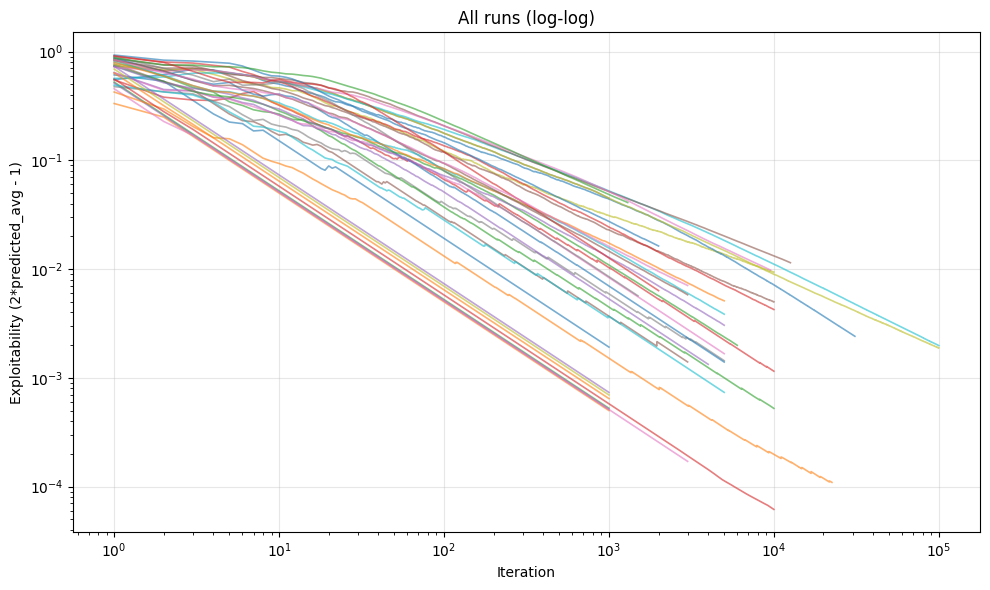

In [4]:
# Overview: all runs
plot_runs(runs, "All runs (log-log)", figsize=(10, 6))


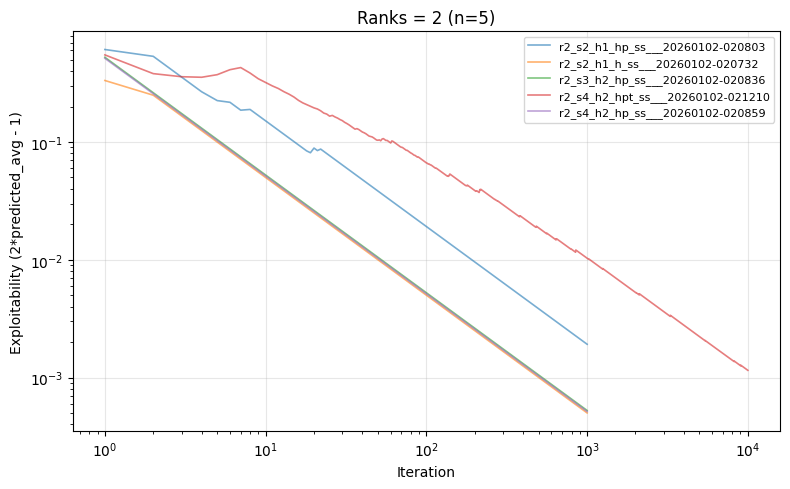

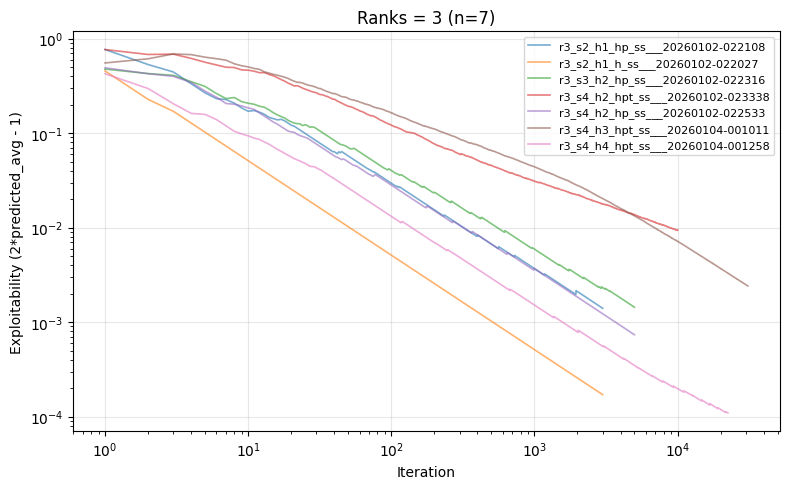

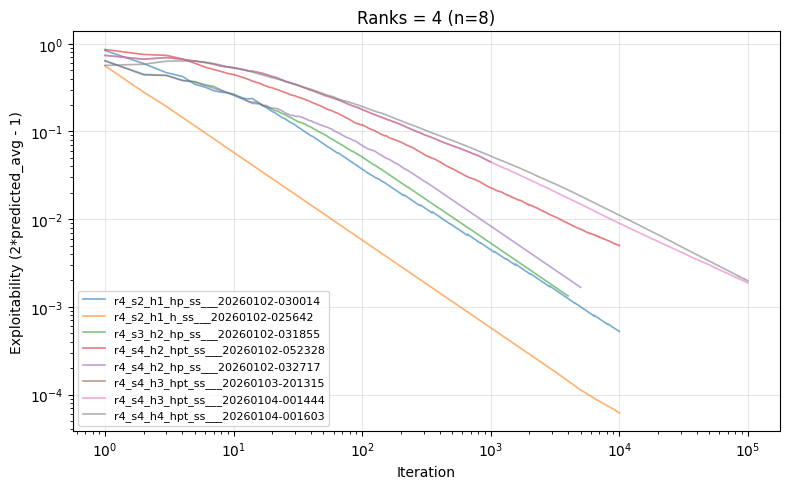

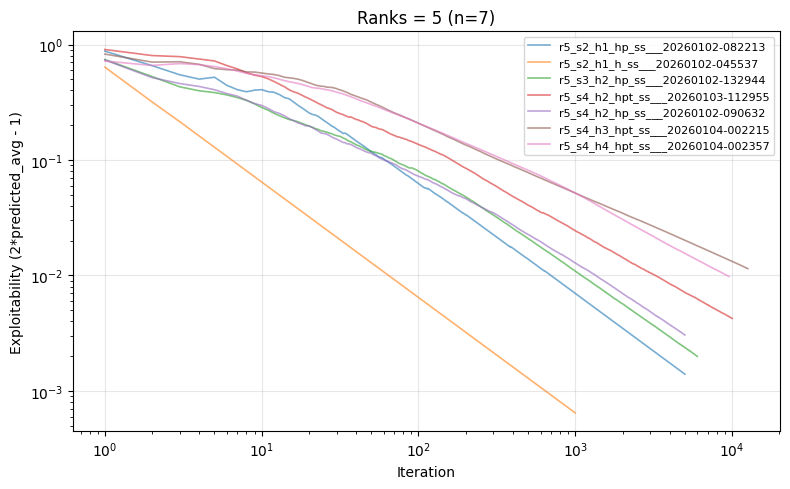

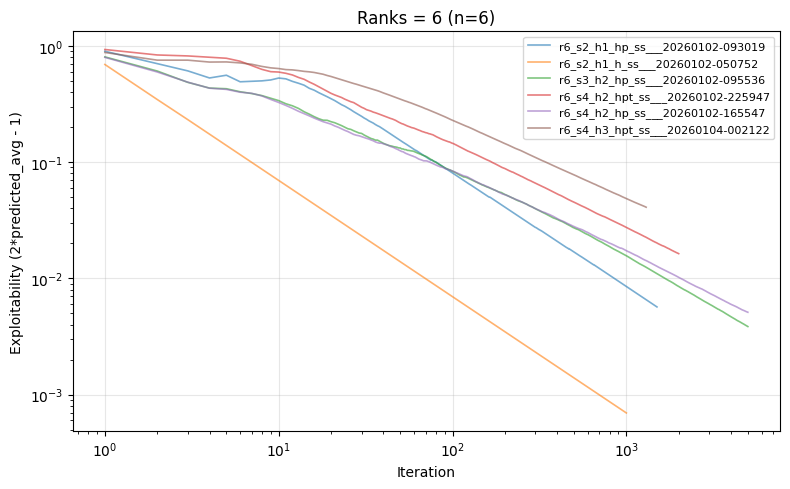

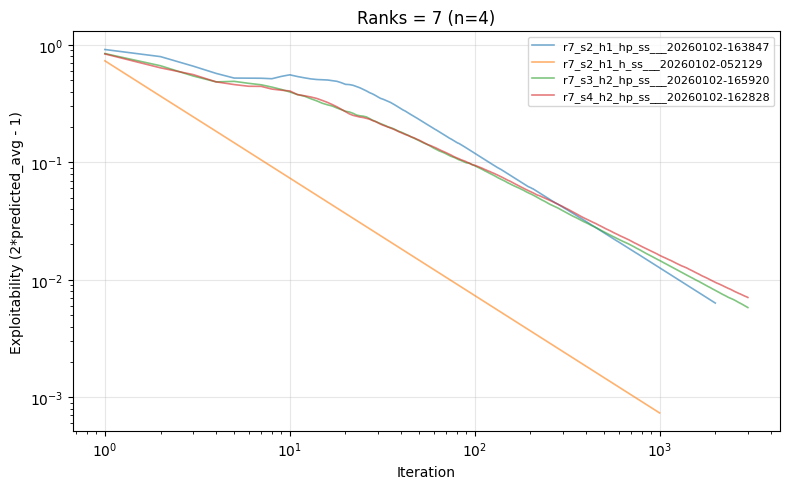

In [5]:
# Group by ranks
by_ranks = {}
for run in runs:
    ranks = run["spec"].get("ranks")
    by_ranks.setdefault(ranks, []).append(run)

for ranks in sorted(by_ranks.keys()):
    group = by_ranks[ranks]
    plot_runs(group, f"Ranks = {ranks} (n={len(group)})", show_legend=True)


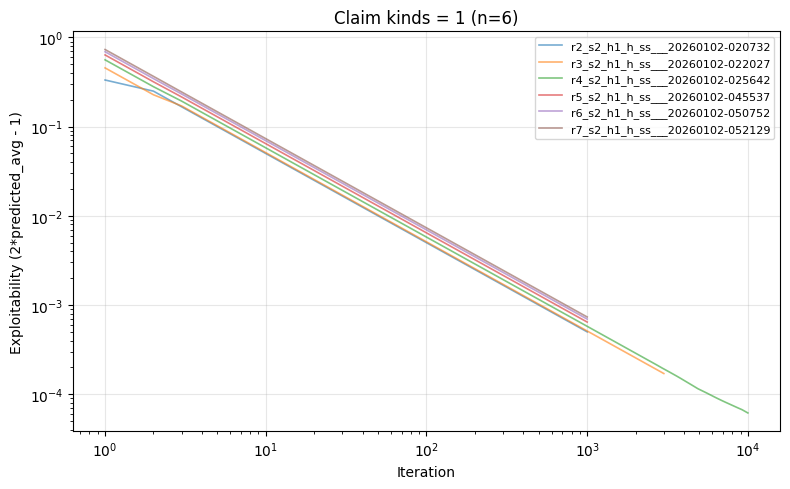

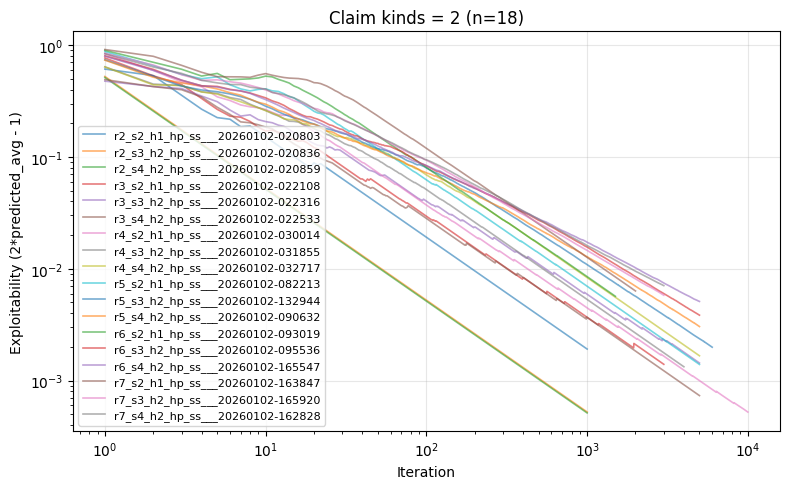

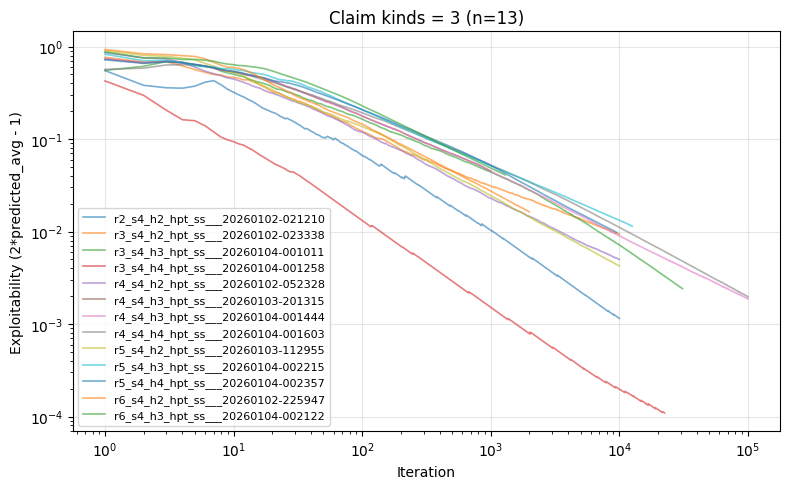

In [6]:
# Group by claim_kinds length
by_claim_len = {}
for run in runs:
    k = len(run["claim_kinds"])
    by_claim_len.setdefault(k, []).append(run)

for k in sorted(by_claim_len.keys()):
    group = by_claim_len[k]
    plot_runs(group, f"Claim kinds = {k} (n={len(group)})", show_legend=True)
